# Abstract

L'obbiettivo del progetto è costruire un circuito quantistico per la compressione e ricostruzione di uno stato a diversi tassi di compressione. Lo stato iniziale a n qubit, viene manipolato da un circuito 2-locale (RealAmplitudes) in cui le rotazioni sono parametri del sistema, da ottimizzare in modo che all'uscita del circuito si trovi una rappresentazione codificata dello stato iniziale in cui venga mantenuta quanta più informazione possibile di esso. Data la natura degli stati e del circuito quantistici, non è possibile addestrare i parametri come in un autoencoder classico. La funzione costo viene ricavata attraverso un ulteriore circuito quantistico detto swap test, che presenta un output classico. L'ottimizazione avviene attraverso un algoritmo classico: COBYLA(Constrained Optimization by Linear Approximation). Si tratta di un metodo iterativo per l'ottimizzazione vincolata senza l'uso di derivate, in modo da evitare la delicata operazione di backpropagation attraverso il circuito quantistico. Vengono prodotte heatmap al fine di caratterizzare il funzionamento del circuito per diversi valori di iperparametri.

# Sezione 1 Introduzione

## Sez 1.1 Modello del circuito

<div style="text-align:center">
    <img src="./immagini/setting.png" alt="Alt Text" width="1000">
    <p><em>Figure 1: lo stato di input è definito sullo spazio latente A e il trash space B. Il reference space (B') e il qubit ausiliario verranno usati nel circuito di SWAP TEST Rif. [2]</em></p>
</div>

La compressione degli stati è realizzata mediante un circuito che opera su $n$ qubit che codificano lo stato originale $|\psi_{AB}\rangle$ , che verranno ridotti a $m$ qubit; i restanti $n-m$ qubit costituiscono il Trash Space, che sarà fondamentale per la misura della funzione costo.
Gli stati su cui si andrà a operare sono $|\Psi\rangle=|\psi_{AB}\rangle\otimes|a_{B'}\rangle$ ovvero lo stato da comprimere e $|a_{B'}\rangle=|0\rangle^{\otimes m}$, usato come reference per una operazione di misura detta swap test.

Considerando il circuito encoder come un generico operatore unitario $U(\theta_i)_{AB}$, il decoder è il corrispondente hermitiano coniugato $U(\theta_i)^\dagger_{AB'}$, con la differenza che il decoder agisce sullo spazio latente (cioè quello dello stato compresso) e sul reference space (quello dello stato di reference $a_{B'}$), che sostituisce i qubit scartati dall'encoder.


<div style="text-align:center">
    <img src="./immagini/schema1.png" alt="Alt Text" width="600">
    <p><em>Figure 2: Struttura del circuito. Rif. [2]</em></p>

</div>


La Loss più naturale per questo learner sarebbe la fedeltà tra lo stato originale e quello ricostruito $\mathcal{L}_1= F(|\psi_{AB}\rangle,\rho^{out})= \langle \psi_{AB} | \rho^{out} | \psi_{AB} \rangle $ ,
dove $\rho^{out}= U(\theta_i)^\dagger_{AB'} Tr_{B}\big[U(\theta_i)_{AB} |\Psi\rangle\langle\Psi| U(\theta_i)^\dagger_{AB} \big] U(\theta_i)_{AB'} $, nella espressione precedente con A si intende il latent space,  B indica il trash space e B' il reference space, il significato dell'espressione è dunque applicare l'encoder, che agisce su A e B, rimuovere il trash con la traccia su B e ricostruire con il decoder, che agisce su A e su B'.
Sfortunatamente siccome nel caso più generale lo stato originale non sarà più accessibile dopo la ricostruzione e non è possibile produrne una copia prima dell'encoding si deve trovare un'alternativa. Se consideriamo l'intero sistema possiamo trovare un modo, usando semplicemente le proprietà del prodotto scalare, siccome per stati puri $F(|\chi\rangle,|\phi\rangle)=|\langle\phi|\chi\rangle|^2$:

\begin{array}{ll}
F(|\psi_{AB}\rangle\otimes|a_{B'}\rangle,U(\theta_i)^\dagger_{AB}V_{BB'}U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle)=\\ \\
=F(U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle,V_{BB'}U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle)=\\ \\
=F(|\psi'_{AB}\rangle\otimes|a_{B'}\rangle,|\psi'_{AB'}\rangle\otimes|a_{B}\rangle)
\end{array}

dove $V_{BB'}$ è l'operatore che scambia i sistemi B e B' e $|\psi'_{AB}\rangle=U(\theta_i)_{AB}|\psi_{AB}\rangle$, nel contesto del sistema che comprende A, B e B' si scambiano reference e trash per effettuare la ricostruzione.  
A questo punto se si prende la traccia nel sistema B', cioè il trash space, si ritorna alla $\mathcal{L}_1$, se invece si traccia su A e B, quindi lo spazio latente e il reference space,  rimane $\mathcal{L}_2=F(|a_{B'}\rangle, \rho'_{B'} )$, cioè la fedeltà tra il reference state e il trash state $\rho'_{B'}=Tr_{AB}\big[|\psi'_{AB'}a_{B}\rangle\langle\psi'_{AB'}a_{B}|\big] $.
Un altro vantaggio di questa strategia è che l'unica operazione richiesta per misurare la Loss coinvolge solo trash state e reference state, senza necessità di ricostruire lo stato in fase di apprendimento, quindi con minore probabilità di errori nel corso dell'esecuzione.
Il principale inconveniente di questa soluzione è che $\mathcal{L}_2 \geq \mathcal{L}_1$, quindi è possibile che la performance che viene effettivamente misurata durante il learning sia sovrastimata, tuttavia nel momento in cui una delle due è massima lo è anche l'altra, in quanto gli stati del sistema complessivo ABB' sono identici, dunque anche tutti gli stati dei sottosistemi lo saranno.

## Sez1.2 SWAP TEST

<div style="text-align:center">
    <img src="./immagini/schema_SWAPTEST.png" alt="Alt Text" width="1000">
    <p><em>Figure 3: circuito SWAP TEST. Rif [2]</em></p>
</div>

La procedura che consente di misurare la Loss consta di una sequenza di entanglement e misura in base computazionale, si inizia con due stati da comparare, che chiameremo genericamente $|\psi\rangle$ e $|\phi\rangle$ e un qubit ancella in $|0\rangle$ oggetto della misura. Si agisce con una porta H sulla ancella, poi la si usa come qubit di controllo in una porta CSWAP su due qubit corrispondenti di $|\psi\rangle$ e $|\phi\rangle$, ripetendo l'operazione fino a scambiare del tutto i due stati, si opera nuovamente con H sull'ancella e infine si misura la medesima in base computazionale. Il risultato di tale procedura è il seguente:

\begin{array}{ll}
|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle \rightarrow \frac{1}{\sqrt{2}}[|0\rangle+|1\rangle]\otimes |\psi\rangle \otimes |\phi\rangle =\\
\frac{1}{\sqrt{2}}[|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle+|1\rangle \otimes |\psi\rangle \otimes |\phi\rangle]\rightarrow \\
\frac{1}{\sqrt{2}}[|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle+|1\rangle \otimes |\phi\rangle \otimes |\psi\rangle]\rightarrow\\
\frac{1}{2}[|0\rangle|\psi\rangle|\phi\rangle+|1\rangle|\psi\rangle|\phi\rangle+|0\rangle|\phi\rangle|\psi\rangle-|1\rangle|\phi\rangle|\psi\rangle]=\\
\frac{1}{2}|0\rangle[|\psi\rangle|\phi\rangle+|\phi\rangle|\psi\rangle]+\frac{1}{2}|1\rangle[|\psi\rangle|\phi\rangle-|\phi\rangle|\psi\rangle]
\end{array}
Ora, la probabilità di misurare $0$ è
\begin{array}{ll}
\frac{1}{4}\big[ \langle \psi \phi|+\langle \phi \psi|\big]\big[ |\psi\phi\rangle+|\phi\psi\rangle \big] =
\frac{1}{2}+\langle \psi \phi|\phi\psi\rangle\langle \phi \psi|\psi\phi\rangle=\\
\frac{1}{2}+\big|\langle \psi \phi|\phi\psi\rangle\big|^2=\frac{1}{2}+\frac{1}{2}F(|\psi\rangle, |\phi\rangle)
\end{array}

dunque misurando ripetutamente lo stesso circuito possiamo ottenere una stima di questa probabilità come frequenza relativa degli zeri su tutti i tentativi.


# Sezione 2 Implementazione

Per implementare il circuito di cui sopra si è usato Qiskit, una libreria Python per la programmazione di circuiti quantistici.

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.circuit.library import RealAmplitudes #RealAmplitudes is a variational form that can be used as ansatz
from qiskit_algorithms.optimizers import COBYLA #COBYLA is a classical optimizer
from qiskit_machine_learning.neural_networks import SamplerQNN 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import json
import time
import warnings

from quantum import * #importing the functions from the quantum.py file

Nel modulo quantum.py sono definite le funzioni AnsatzeBuilder, SwaptestBuilder ed EncoderBuilder che restituiscono i corrispondenti circuiti quantistici (si veda file per dettagli).

### Sez 2.1 Costruzione del Encoder

Si definiscono lo stato iniziale che si vuole comprimere (q), la dimensione dello stato compresso e la profondità del circuito parametrico RealAmplitudes associato all'encoder. Viene costruito l'encoder attraverso la funzione EncoderBuilder, che restituisce un circuito composto dal circuito parametrico RealAmplitudes seguito dal circuito che esegue lo SWAP test.

In [2]:
#Parametri
q = [0,0,1,1,1,0,0,0,0,0] #input state
EncodedStateDimension = 3
Depth = 3

#Costruisco encoder
InputStateDimension = len(q)
Encoder = EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth)
#Costruisco circuito generico, resetto qubit a 0 e applico X ai qubit 2,3,4
Circuit = QuantumCircuit(Encoder.num_qubits, Encoder.num_clbits)
for i in range(Circuit.num_qubits):
    Circuit.reset(i)
for i in range(InputStateDimension):
    if q[i] == 1:
        Circuit.x(i)
Circuit.compose(Encoder, inplace=True)
#Circuit.draw('mpl', filename='circuit.png')
#Circuit.draw()

<div style="text-align:center">
    <img src="./immagini/circuit.png" alt="Alt Text" width="1000">
    <p><em>Figure 4: schema circuito completo. q = [0,0,1,1,1,0,0,0,0,0], EncodedStateDimension = 3, Depth = 3</em></p>

</div>


Si salva lo stato iniziale, utile per valutare la fidelity al termine della ricostruzione dello stato compresso.

In [3]:
original_state = QuantumCircuit(len(q))
for i in range(original_state.num_qubits):
    original_state.reset(i)
for i in range(InputStateDimension):
    if q[i] == 1:
        original_state.x(i)
#original_state.draw()

<div style="text-align:center">
    <img src="./immagini/OriginalState.jpeg" alt="Alt Text" width="200">
    <p><em>Figure 5: schema stato iniziale. q = [0,0,1,1,1,0,0,0,0,0]</em></p>

</div>

#### Sez 2.1.1 RealAmplitudes

Per implementare un encoder con un circuito quantistico è necessario definire l'operatore unitario $U(\theta_i)$, in modo che il numero di gate (e quindi di parametri) scali in modo polinomiale rispetto al numero di qubit di input. Una delle possibilità è quella di impiegare un circuito "modulare", in cui un circuito "modulo" viene ripetuto un certo numero di volte (Depth del circuito). Abbiamo utilizzato un circuito 2-locale, che permettesse rotazione di ogni singolo qubit ad ogni layer e entanglement tra 2 qubit adiacenti. Un semplice circuito parametrico 2-locale già presente nella libreria qiskit è RealAmplitudes (Figura 3).

<div style="text-align:center">
    <img src="./immagini/schema_RealAmplitudes.png" alt="Alt Text" width="1000">
    <p><em>Figure 6: schema circuito RealAmplitudes. InputDimension = 5, Depth = 5</em></p>
</div>

#### Sez2.1.2 SWAP TEST

Per addestrare $U(\theta_i)$ alla compressione degli stati, è necessario calcolare una funzione costo. Come descritto nella sezione 1.2 la funzione costo è misurata come la fedeltà del Trash Space al Reference Space, della stessa dimensione del precedente e composto da qubit nello stato |0>. Una volta applicato il circutio la fedeltà tra i due blocchi può essere misurata come la probabilità di misurare |0> sul qubit ancella. La funzione SwaptestBuilder ritorna il circuito di swap test con un operatore di misura sul qubit ancella verso un canale classico.

<div style="text-align:center">
    <img src="./immagini/SWAP.png" alt="Alt Text" width="500">
    <p><em>Figure 7: schema circuito SWAPTEST con Trash Space dimension = 7</em></p>
</div>

### Sez 2.2 Addestramento

<div style="text-align:center">
    <img src="./immagini/hybrid.png" alt="Alt Text" width="500">
    <p><em>Figure 8: Rappresentazione del sistema ibrido classico-quantistico per l'addestramento dell'autoencoder. Rif.[1]</em></p>
</div>

Possiamo definire la funzione costo come la probabilità di ottenere |1> sul qubit ancella. Questo dato classico può essere passato ad un ottimizzatore classico per il calcolo di un nuovo set di parametri.

La funzione di qiskit SamplerQNN funge da interfaccia tra il circuito parametrico costruito fin ora e il simulatore di qiskit (Aer). In particolare vengono passati alla funzione circuito, parametri da ottimizzare e parametri iniziali. Gli argomento interpreter e output_shape dipendono dal circuito che stiamo passando e dal simulatore.

In [4]:
# Interprete per SamplerQNN
def identity_interpret(x):
    return x

qnn = SamplerQNN(
    circuit=Circuit, #circuito completo
    input_params=[], #guess iniziale lasciato a SamplerQNN, quindi randomici
    weight_params=Circuit.parameters, #identificato i parametri del circuito, quindi i parametri di RealAmplitudes
    interpret=identity_interpret,
    output_shape=2, #l'output del circuito può essere 1 o 0, una stringa binaria di dimensione 2
)

Definiamo cost_function che calcola la funzione costo dato un set di parametri in input. I parametri vengono passati al simulatore e otteniamo le nuove probabilità. Ogni valore di cost viene salvato in un array, che viene plottato ogni volta che la funzione viene chiamata.

In [5]:
def cost_function(params_values):
    #calcolo probabilità passando i nuovi parametri
    probabilities = qnn.forward([], params_values)
    # probabilità di ottenere 1 come output della simulazione, cioè la funzione costo
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost


#### Sez 2.2.1 COBYLA

Constrained Optimization BY Linear Approximations (Rif. [3]) è un algoritmo di ottimizzazione di ricerca diretta, per ricerca diretta si intende un metodo per risolvere problemi di ottimizzazione che non richiede alcuna informazione sul gradiente della funzione obiettivo. A differenza dei metodi di ottimizzazione più tradizionali che utilizzano gradienti o derivate di ordine superiore per cercare un punto ottimale, un algoritmo di ricerca diretta esplora un insieme di punti intorno al punto corrente, cercandone uno in cui il valore della funzione obiettivo sia inferiore rispetto al valore nel punto corrente.
Quindi, COBYLA è in grado di risolvere problemi espressi nella forma:

\begin{cases}
    \text{Minimizzo } F(\mathbf{x}), & \mathbf{x} \in \mathbb{R}^n \\
    \text{soggetta a } c_i(\mathbf{x}) \geq 0, & i = 1, \ldots, m
\end{cases}

Per farlo si basa sull'idea dell'algortimo di Nelder e Mead di utilizzare dei simplessi non degeneri in $\mathbb{R}^n$. Così facendo si può dire che esistono delle funzioni lineari uniche $\hat{F}$ e $\hat{c}_i$ che interpolano $F$ e $c_i$ ai vertici. Quindi, l'obiettivo originario viene approssimato da un problema di programmazione lineare:

\begin{cases}
   \text{minimizzo } \hat{F}(\mathbf{x}), & \mathbf{x} \in \mathbb{R}^n \\
   \text{soggetta a } \hat{c}_i(\mathbf{x}) \geq 0, & i = 1, \ldots, m
\end{cases}


Operativamente, l'algoritmo parte generando un set di punti $\textbf{x}^{(j)}$, con $j = 0, ..., n$, i quali sono i vertici del simplesso, prende in input un valore $\rho > 0$ che è il raggio di una regione di confidenza, questa si riferisce all'area in cui la funzione obiettivo viene approssimata da un modello più semplice, ed infine un $\mu > 0$ che è il parametro di una funzione di merito per il confronto tra due $\textbf{x}$.
La funzione di merito è:

$$
\Phi(\textbf{x}) = F(\textbf{x}) + \mu \left[ \text{max}\{ -c_i(\textbf{x}):\; i=1, ...,m \} \right]_+,\; \textbf{x} \in \mathbb{R}^n
$$

questa funzione serve per determinare l'ottimalità di un punto $\textbf{x}$ rispetto ad un altro, un vettore $i$ è migliore di un altro $j$ se e soltanto se $\Phi(\text{x}_i)<\Phi(\text{x}_j)$. Infatti un punto è tanto buono quanto rispetta i constraint del problema, se un punto non li rispetta avrà alcuni $c_i < 0$, per cui prendendo il massimo dei valori non rispettati, moltiplicato per un certo fattore $\mu$, e sommandolo al valore originario della funzione, si penalizza quel determinato punto. Il pedice $+$ significa che la parentesi quadra viene messa a zero se tutti i constraint sono soddisfatti per quel punto.

Una volta presi i punti iniziali, l'algoritmo li ordina per bontà, di modo che $\Phi(\textbf{x}^{(0)}) \leq \Phi(\textbf{x}^{(j)})$ per $j = 1, ..., n$. Dopodiché, si trovano dei candidati $\textbf{x}^{(*)}$ minimi della funzione, per farlo se possibile si risolve il sistema linearizzato controllando che sia rispettata la condizione:

$$
||\textbf{x}^{(*)} - \textbf{x}^{(0)}||_2 \leq \rho
$$

e i constraint:

$$
\hat{c}_i(x^{(*)}) \geq 0,\; i = 1, ..., m
$$

se sono tutte verificate e ci sono più candidati, allora si prende il punto che dà il minimo valore di $||\textbf{x}^{(*)} - \textbf{x}^{(0)}||_2$.
Può capitare che le due diseguaglianze siano in contraddizione, se ciò accade violando la seconda, si definisce $\textbf{x}^{(*)}$ minimizzando le violazioni dei constraint lineari, tenendo conto della regione di confidenza. Se c'è ancora ambiguità, si guardano i valori di $\hat{F}$ e si prende quello che li minimizza. E se a questo punto non c'è ancora una sola scelta, il candidato migliore è quello che minimizza $||\textbf{x}^{(*)} - \textbf{x}^{(0)}||_2$.

Anche $\mu$ varia e lo fa in base ai valori di $\textbf{x}^{(*)}$. Inizialmente $\mu$ è un valore positivo molto piccolo, ma un valore troppo vicino a zero potrebbe portare la condizione $\hat{\Phi}(\textbf{x}^{(*)}) < \hat{\Phi}(\textbf{x}^{(0)})$ a non essere verificata, dove le $\hat{\Phi}$ sono le stesse di prima ma con il problema linearizzato. Quindi, se $\mu$ non è grande abbastanza va revisionato. Sia $\bar{\mu}$ il più piccolo valore di $\mu$ non negativo che soddisfa $\hat{\Phi}(\textbf{x}^{(*)}) < \hat{\Phi}(\textbf{x}^{(0)})$, il valore rimane fisso se $\mu > \frac{3}{2}\bar{\mu}$, altrimenti $\mu$ viene sostituito con $2\hat{\mu}$. $\Phi(\textbf{x}^{(0)}) \leq \Phi(\textbf{x}^{(j)})$ per $j = 1, ..., n$ potrebbe non essere più verificato dopo l'aggiornamento di $\mu$, se questo succede allora si scambiano coppie di vertici e si ricalcola $\mu$ fino a quando la situazione diventa accettabile.

Ora si vede come si aggiorna $\rho$, innanzitutto questo valore o rimane invariato o viene ridotto, ma non può mai diventare più grande. L'aggiornamento avviene se

$$||\textbf{x}^{(*)} - \textbf{x}^{(0)}||_2 < \frac{1}{2}\rho
$$

oppure,

$$\Phi(\textbf{x}^{(0)}) - \Phi(\textbf{x}^{(*)}) < 0.1 \left[ \hat{\Phi}(\textbf{x}^{(0)}) - \hat{\Phi}(\textbf{x}^{(*)}) \right]$$

questa seconda condizione significa che l'aggiornamento da $\textbf{x}^{(0)}$ a $\textbf{x}^{(*)}$ porterebbe a meno di un decimo del miglioramento predetto dall'approssimazione lineare.
Il nuovo valore del raggio $\rho_{\text{new}}$ viene posto uguale a $\frac{1}{2} \rho$ se $\rho > 3 \rho_{\text{end}}$, altrimenti $\rho_{\text{new}} = \rho_{\text{end}}$, dove $\rho_{\text{end}}$ è la precisione numerica che si vorrebbe ottenere sulla soluzione, ed è dato in input dall'utente, e quando questa viene raggiunta l'algoritmo si ferma.
Una diminuzione della regione di confidenza potrebbe rendere il simplesso non accettabile, il simplesso è accettabile se


\begin{cases}
   \sigma^{(j)} \geq \alpha \rho \\
   \eta^{(j)} \geq \beta \rho
\end{cases}


per $j = 1, ..., n$, e $\alpha$ e $\beta$ sono costanti scelta in modo da avere $0<\alpha<1<\beta$.

Il simplesso iniziale viene scelto a partire da $\rho_{\text{beg}}$, che è il raggio iniziale della regione di confidenza, e da un punto $\textbf{x}^{(0)}$, che a seconda delle implementazioni può essere dato in input dall'utente, oppure scelto a caso dal computer. Il simplesso dovrà avere $n+1$ vertici, quindi il programma cicla su $j = 0, ..., n$ e imposta $\textbf{x}^{(j)} = \textbf{x}^{(0)} + \rho_{\text{beg}} \textbf{e}_j$, dove $\textbf{e}_j$ è un vettore di dimensione $n$ con entrate $i \neq j$ uguali a $0$, e $1$ in $i = j$, inoltre $\textbf{x}^{(0)}$ viene scambiato con $\textbf{x}^{(j)}$ se e soltanto se $F(\textbf{x}^{(j)}) < F(\textbf{x}^{(0)})$. Il primo simplesso non deve rispettare le condizioni di accettabilità.

Il vettore $\textbf{x}^{(*)}$ non è calcolato ad ogni iterazione, talvolta è preferibile dare priorità alla costruzione di un simplesso accettabile e quindi calcolare un altro punto $\textbf{x}^{(\Delta)}$.

$\textbf{x}^{(*)}$ viene calcolato se una di queste condizioni è soddisfatta: è la prima iterazione. L'iterazione precedente ha ridotto $\rho$. L'iterazione precedente ha calcolato $\textbf{x}^{(\Delta)}$. L'iterazione precedente ha calcolato $\textbf{x}^{(*)}$ e ha ridotto la funzione di merito almeno di un decimo del valore aspettato. Il simplesso attuale è accettabile.
$\textbf{x}^{(\Delta)}$ è definito come segue: se un qualsiasi valore $\eta^{(j)}$ è maggiore di $\beta \rho$, allora definiamo $l$ come l'intero più piccolo tra gli indici $1, ..., n$ che soddisfa l'equazione:
$$
\eta^{(l)} = \max \{ \eta^{(j)}:\; j=1, ...,n \} 
$$

altrimenti:

$$
\sigma^{(l)} = \min \{ \sigma^{(j)}:\; j=1, ...,n \} 
$$

Si prende $\textbf{v}^{(l)}$, vettore unitario perpendicolare alla faccia opposta al vertice che verrà sostituito, perciò:

$$
\textbf{x}^{(\Delta)} = \textbf{x}^{(0)} \pm \gamma \rho \textbf{v}^{(l)}
$$

dove $\pm$ indica che si sceglierà il segno dell'operazione in base a quella che minimizza $\hat{\Phi}(\textbf{x}^{(\Delta)})$\, e $\gamma$ è una costante compresa tra $\alpha$ ed $1$.

### Sez. 2.3 Risultati

Abbiamo a questo punto addestrato l'encoder con i parametri fissati nella sezione 2.1 su 300 iterazioni di COBYLA plottando la loss ad ogni iterazione.

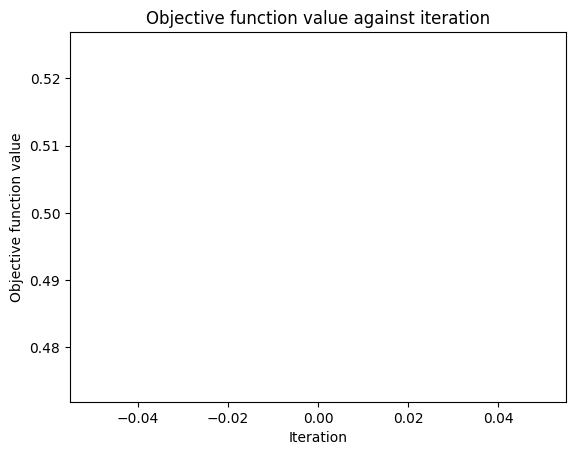

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [6]:
objective_func_vals = []
# Initialize the COBYLA optimizer
opt = COBYLA(maxiter=300)
num_parameters = Circuit.num_parameters
initial_point = np.random.rand(num_parameters)  # Set the initial parameters
print('Number of parameters in quantum circuit: ',Circuit.num_parameters)
print('Initial parameters in quantum circuit: ',initial_point)

# Perform optimization
start = time.time()
opt_result = opt.minimize(cost_function,initial_point)
#print('Cost function value:', cost_function(initial_point))
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

<div style="text-align:center">
    <img src="./immagini/plot_loss-time.png" alt="Alt Text" width="500">
    <p><em>Figure 9: plot loss-time.</em></p>
</div>

Al termine del processo di ottimizzazione è possibile costruire il decoder e aggiungerlo all'encoder, in questo modo si riesce a ricostruire lo stato originario a partire dal suo encoding nello spazio latente.

In [8]:
test_qc = QuantumCircuit(len(q))
test_qc = test_qc.compose(original_state)
ansatz_qc = AnsatzBuilder(len(q), Depth)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(9)
test_qc.reset(8)
test_qc.reset(7)
test_qc.reset(6)
test_qc.reset(5)
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())
test_qc.draw('mpl', filename='test_circuit.png')

<div style="text-align:center">
    <img src="./immagini/Autoencoder.jpeg" alt="Alt Text" width="1000">
    <p><em>Figure 10: Autoencoder.</em></p>
</div>

Ai parametri del circuito vengono assegnati i risultati calcolati da COBYLA.

In [ ]:
test_qc = test_qc.assign_parameters(opt_result.x)

Ora ci sono sono tutti gli ingredienti per poter misurare la fidelity tra lo stato ricostruito e lo stato originario.

In [ ]:
from qiskit.quantum_info import Statevector

original_state = Statevector(original_state).data
output_state = Statevector(test_qc).data

fidelity = np.abs(np.dot(original_state.conj(), output_state))
print("Fidelity of our Output State with our Input State: ", fidelity)

Fidelity of our Output State with our Input State:  0.9968967329295054


# Sezione 3 Caratterizzazione

Il circuito ha diversi iperparametri, la scelta di questi ha sicuramente un effetto sul suo funzionamento e quindi sui risultati finali. In questa sezione si propone una caratterizzazione dell'autoencoder quantistico per valutare l'influenza di questi iperparametri. A tal fine si considerano stati di dimensione $n$, al massimo di $n = 10$ qubit, questi vengono compressi in stati di dimensione da 1 fino a stati di dimensione $n-1$, e per ciascun encoding si calcola la fidelity e l'ultimo valore della loss. Questi valori vengono visualizzati con delle heat map, mostrando il comportamente del circuito.

In [ ]:
import copy

In [ ]:
%%time
fidelity_range = 10
fidelity_matrix = np.zeros((fidelity_range, fidelity_range))

last_score_matrix = copy.deepcopy(fidelity_matrix)
std_fidelity_matrix = copy.deepcopy(fidelity_matrix)
std_last_score_matrix = copy.deepcopy(fidelity_matrix)

Depth = 5 #Depth of the encoder

opt = COBYLA(maxiter = 200, tol = 1e-2)

k = 0 # Counter for the number of iterations
reps = 5 # How many times do we want to repeat the compression

tot = ((fidelity_range - 1) * fidelity_range / 2) * reps  # Total number of iterations = number of entries * number of reps

np.random.seed(42) #set a seed for repeatability 

for i in range(1, fidelity_range + 1, 1): # for loop on input dimensions
    
    for j in range(1, i, 1): # for loop on output dimensions
        
        data_fid = np.empty(reps) # array for computing the std of the fidelity value
        data_last_sc = np.empty(reps) # array for computing the std of the last score value
                
        for rep in range(reps):

            k = k + 1 # update to keep track of the process

            clear_output(wait=True)
            print('{:.0f}'.format((k / tot) * 100), "%") #print the progress of the process

            q = list(np.random.randint(2, size = i)) # state to compress

            InputStateDimension = i

            original_state = QuantumCircuit(len(q))
            for z in range(original_state.num_qubits):
                original_state.reset(z)
            for z in range(InputStateDimension):
                if q[z] == 1:
                    original_state.x(z)

            EncodedStateDimension = j


            # Costruisco encoder

            Encoder = EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth)
            # Costruisco circuito generico
            Circuit = QuantumCircuit(Encoder.num_qubits, Encoder.num_clbits)
            for z in range(Circuit.num_qubits):
                Circuit.reset(z)
            for z in range(InputStateDimension):
                if q[z] == 1:
                    Circuit.x(z)

            Circuit.compose(Encoder, inplace = True)

            qnn = SamplerQNN(
                circuit=Circuit, # circuito completo
                input_params=[], # guess iniziale lasciato a SamplerQNN, quindi randomici
                weight_params=Circuit.parameters, # identificato i parametri del circuito, quindi i parametri di RealAmplitudes
                interpret=identity_interpret,
                output_shape=2, # l'output del circuito può essere 1 o 0, una stringa binaria di dimensione 2
            )

            objective_func_vals = []

            # Initialize the COBYLA optimizer
            num_parameters = Circuit.num_parameters
            initial_point = np.random.rand(num_parameters)  # Set the initial parameters

            # Perform optimization
            opt_result = opt.minimize(cost_function, initial_point)

            # Build the decoder
            test_qc = QuantumCircuit(len(q))
            test_qc = test_qc.compose(original_state)
            ansatz_qc = AnsatzBuilder(len(q), Depth)
            test_qc = test_qc.compose(ansatz_qc)
            test_qc.barrier()
            for z in range(i - j):
                test_qc.reset(i - 1 - z)
            test_qc.barrier()
            test_qc = test_qc.compose(ansatz_qc.inverse())
            test_qc = test_qc.assign_parameters(opt_result.x)

            # Perform fidelity measure
            original_state = Statevector(original_state).data
            output_state = Statevector(test_qc).data

            f = np.abs(np.dot(original_state.conj(), output_state)) # Compute fidelity
            
            fidelity_matrix[fidelity_range - i, j - 1] = fidelity_matrix[fidelity_range - i, j - 1] + copy.deepcopy(f)

            last_score_matrix[fidelity_range - i, j - 1] = last_score_matrix[fidelity_range - i, j - 1] + (1 - copy.deepcopy(objective_func_vals[-1]))
            
            data_fid[rep] = copy.deepcopy(f)
            data_last_sc[rep] = (1 - copy.deepcopy(objective_func_vals[-1]))
            
            
        std_fidelity_matrix[fidelity_range - i, j - 1] = np.std(data_fid)
        std_last_score_matrix[fidelity_range - i, j - 1] = np.std(data_last_sc)

In [ ]:
import seaborn as sns

# Specify custom x and y axis labels
x_labels = list(np.arange(1, fidelity_range + 1))
y_labels = x_labels[::-1]

fidelity_matrix = fidelity_matrix / reps

# Create a heatmap using seaborn

plt.figure(figsize=(10, 8))

sns.heatmap(fidelity_matrix, xticklabels=x_labels, yticklabels=y_labels, annot=True, cmap="YlGnBu")

# Add labels and title
plt.xlabel('Encoded Dimension')
plt.ylabel('Input Dimension')
plt.title('Limiti di convergenza, Fidelity, depth = 5')

# Show the plot
plt.show()

<div style="text-align:center">
    <img src="./immagini/fid_depth5.png" alt="Alt Text" width="1000">
    <p><em>Figure 11: Heat Map della fidelity per un autoencoder di profondità 5.</em></p>
</div>

E variando la profondità si costruisco i plot per $\text{depth} = 2, 5, 10$ di fidelity e 1 - Loss.

<table><tr>
<td> <img src="./immagini/fid_depth2.png" alt="Alt Text" width="600"> </td>
<td> <img src="./immagini/fid_depth5.png" alt="Alt Text" width="600"> </td>
<td> <img src="./immagini/fid_depth10.png" alt="Alt Text" width="600"> </td>
</tr></table>
<p><em>Figure 12: Heat Maps della fidelity per un autoencoder di profondità 2, 5 e 10.</em></p>

<table><tr>
<td> <img src="./immagini/lsc_depth2.png" alt="Alt Text" width="600"> </td>
<td> <img src="./immagini/lsc_depth5.png" alt="Alt Text" width="600"> </td>
<td> <img src="./immagini/lsc_depth10.png" alt="Alt Text" width="600"> </td>
</tr></table>

<p><em>Figure 13: Heat Maps di 1 - Loss per un autoencoder di profondità 2, 5 e 10.</em></p>

Il primo risultato evidente di queste immagini è che più si cerca di comprimere, ovvero più la dimensione dello stato di partenza e la dimensione dello stato compresso sono distanti, più i risultati non sono ottimali. Infatti, si vede chiaramente per esempio, che la compressione con peggiori performance è quella che riguarda lo stato di dimensione 10.
Si può anche osservare come l'ottimizzazione peggiori all'aumentare dell'iperparametro di depth, questo è devuto al fatto che COBYLA lavora meglio su problemi a bassa dimensionalità, aumentando eccessivamente la dimensione dello spazio da esplorare, il volume di questo esplode e quindi l'algoritmo ha difficoltà a ricercare minimi. Inoltre, ad alte dimensioni le funzioni target potrebbero diventare fortemente non lineari, e siccome COBYLA lavora con approssimazioni lineari della funzione, queste potrebbero diventare poco accurate. Ed infine, siccome il metodo implementa una ricerca locale del minimo intorno ad una guess iniziale, a causa dell'alta dimensionalità, e quindi dell'alta non linearità del target, la ricerca potrebbe rimanere bloccata in un minimo locale.

# Bibliografia

[1]  Jonathan Romero, Jonathan P. Olson and Alan Aspuru-Guzik, "Quantum autoencoders for efficient compression of quantum data", Quantum Science and Technology, 2017

[2] Qiskit machine learning tutorials, "The quantum autoencoder", https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html

[3] Powell, M J D. A direct search optimization method that models the objective and constraint functions by linear interpolation. 1994. Advances in Optimization and Numerical Analysis, eds. S. Gomez and J-P Hennart, Kluwer Academic (Dordrecht), 51-67.